In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

import os
import numba
from numba import jit

# Parámetros
Lx, Ly = 10, 50   # dimensiones del dominio
v = 2.5
T = 2*(Ly)/(v) # tiempo total

nx =  450 # número de intervalos en x y y
ny = nx
dx = Lx / (nx - 1)  # tamaño del intervalo en x
dy = Ly / (ny - 1)  # tamaño del intervalo en y


l_screen = 2.5


f = v/l_screen

lambda_ = l_screen

k = 2 * np.pi / lambda_


safety_factor = np.sqrt(1/2) * 0.9  # factor de seguridad


# Calcular dt para cumplir con la condición de CFL
dt = np.sqrt((dx**2 * dy**2) / (dx**2 + dy**2)) / v


nt = int(T / dt) + 1  # número de intervalos de tiempo

nt


4579

In [61]:


# Calcular el número total de elementos
num_elements = nx * ny * nt

# Determinar el tamaño de cada elemento (en bytes)
element_size = np.dtype(np.float64).itemsize  # 8 bytes para float64

# Calcular el tamaño total en bytes
total_size_bytes = num_elements * element_size

# Convertir a megabytes (1 MB = 1,048,576 bytes)
total_size_mb = total_size_bytes / (1024 ** 3)

print(f"El tamaño estimado de la matriz u es de {total_size_mb:.2f} GB")



El tamaño estimado de la matriz u es de 6.91 GB


In [62]:
v*dt <= np.sqrt((dx**2 * dy**2) / (dx**2 + dy**2))

True

In [14]:
v_name = f'backup2D_difra.mp4'
os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")


-2

In [332]:
#Intereferencia de dos fuentes puntuales

# Inicializar la solución como una matriz de ceros
u = np.zeros((nx, ny, nt))

# Condiciones iniciales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Parámetros de la gaussiana
sigma = 0.2  # desviación estándar de la gaussiana
x0, y0 = 8, 13

x1,y1 = x0+8, 13

A = 0.5
epsilon = 1e-1  # Pequeña constante para evitar división por cero

# Inicializar la onda como una onda plana paralela a X
u[:, :, 0] = A * np.cos(k * np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2) + epsilon) / (np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2) + epsilon) + \
         A * np.cos(k * np.sqrt((X[:] - x1)**2 + (Y[:] - y0)**2) + epsilon) / (np.sqrt((X[:] - x1)**2 + (Y[:] - y0)**2) + epsilon)

@numba.jit
def propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, y0, A, k, epsilon):
    
    for t in range(0, nt-1):
        u[:, :, 1] = u[:, :, 0]
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                u[i, j, t+1] = (2 * u[i, j, t] - u[i, j, t-1] + v**2 * dt**2 * (u[i+1, j, t] - 2 * u[i, j, t] + u[i-1, j, t]) / dx**2 + v**2 * dt**2 * (u[i, j+1, t] - 2 * u[i, j, t] + u[i, j-1, t]) / dy**2)
        
        # Condiciones de frontera absorbentes (simplemente fijar a cero)
        #u[0, :, t+1] = 0
        #u[-1, :, t+1] = 0
        #u[:, 0, t+1] = 0
        #u[:, -1, t+1] = 0
        # Añadir las fuentes en cada paso de tiempo
        #u[:, :, t+1] += A * np.sin(- 2 * np.pi * f * t * dt)*np.cos(k * np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2) + epsilon ) / (np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2) + epsilon)
        #u[:, :, t+1] += A *np.sin(- 2 * np.pi * f * t * dt)* np.cos(k * np.sqrt((X[:] - x1)**2 + (Y[:] - y1)**2)+ epsilon ) / (np.sqrt((X[:] - x1)**2 + (Y[:] - y1)**2) + epsilon)
    
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, y0, A, k, epsilon)

In [394]:
#Reflexión en una placa diagonal

# Inicializar la solución como una matriz de ceros
u = np.zeros((nx, ny, nt))

# Condiciones iniciales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Parámetros de la fuente
A = 0.5  # Amplitud de la fuente

epsilon = 1e-1 

x0, y0 = Lx/2, 0  # Posición de la fuente

@numba.jit(nopython=True)
def propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, y0, k, epsilon, Lx, Ly):
    def is_on_plate(x, y):
        # Ecuación de la línea diagonal: y = (Ly / Lx) * x + (Ly / 2)
        return np.isclose(y, (Ly / Lx) * x + (Ly / 2), atol=dy/2)

    for t in range(0, nt-1):
        u[:, :, t+1] = u[:, :, t]
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                # Aplicar condiciones de frontera para la placa diagonal
                if not is_on_plate(X[i, j], Y[i, j]):
                    u[i, j, t+1] = (2 * u[i, j, t] - u[i, j, t-1] + v**2 * dt**2 * (u[i+1, j, t] - 2 * u[i, j, t] + u[i-1, j, t]) / dx**2 + v**2 * dt**2 * (u[i, j+1, t] - 2 * u[i, j, t] + u[i, j-1, t]) / dy**2)
                #else:
                    # Condiciones de frontera de Neumann (reflexión)
                   # if i > 0 and i < nx-1:
                       # u[i, j, t+1] = u[i, j, t] + (u[i+1, j, t] - u[i-1, j, t]) / (2 * dx)
                    #if j > 0 and j < ny-1:
                        #u[i, j, t+1] = u[i, j, t] + (u[i, j+1, t] - u[i, j-1, t]) / (2 * dy)
        
        # Condiciones de frontera absorbentes (simplemente fijar a cero)
        u[0, :, t+1] = 0
        u[-1, :, t+1] = 0
        u[:, 0, t+1] = 0
        u[:, -1, t+1] = 0
        
        # Añadir las fuentes en cada paso de tiempo
        for i in range(nx):
            for j in range(ny):
                u[i, j, t+1] += A * np.sin(-2 * np.pi * f * t * dt) * np.cos(k * np.sqrt((X[i, j] - x0)**2 + (Y[i, j] - y0)**2) + epsilon) / (np.sqrt((X[i, j] - x0)**2 + (Y[i, j] - y0)**2) + epsilon)
    
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, y0, k, epsilon, Lx, Ly)

In [67]:
#Plana Laminas

# Inicializar la solución como una matriz de ceros
u = np.zeros((nx, ny, nt))

# Condiciones iniciales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Parámetros de la gaussiana
sigma = 0.2  # desviación estándar de la gaussiana
x0, y0 = Lx/2, 0

A = 2
epsilon = 1e-12  # Pequeña constante para evitar división por cero

# Parámetros de las láminas
s = 1 # Separación entre las láminas
y_lamina = Ly/5 # Las láminas están a 10 unidades de la fuente
x_lamina1 = x0 - s / 2
x_lamina2 = x0 + s / 2
longitud_lamina = (Lx-s)/2 # Longitud de cada lámina

@numba.jit
def propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, epsilon, y_lamina, x_lamina1, x_lamina2, longitud_lamina):
    
    for t in range(0, nt-1):
        #u[:, :, 1] = u[:, :, 0]
        
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                # Aplicar condiciones de frontera para las láminas
                if not (y_lamina - dy/2 < Y[i, j] < y_lamina + dy/2 and (X[i, j] < x_lamina1 or X[i, j] > x_lamina2)):
                    u[i, j, t+1] = (2 * u[i, j, t] - u[i, j, t-1] + v**2 * dt**2 * (u[i+1, j, t] - 2 * u[i, j, t] + u[i-1, j, t]) / dx**2 + v**2 * dt**2 * (u[i, j+1, t] - 2 * u[i, j, t] + u[i, j-1, t]) / dy**2)
        
        # Condiciones de frontera absorbentes (simplemente fijar a cero)
        u[0, :, t+1] = 0
        u[-1, :, t+1] = 0
        u[:, 0, t+1] = 0
        u[:, -1, t+1] = 0
        
        # Añadir la fuente en cada paso de tiempo
        u[:, :, t+1] += A * np.sin(- 2 * np.pi * f * t * dt) * np.sin(k * (Y[:] - y0))*np.sin(np.pi*(X[:])/Lx)/np.sqrt((X[:] - x0)**2 + 5*(Y[:] - y0)**2 + epsilon) #/np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2 + epsilon)
    
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, epsilon, y_lamina, x_lamina1, x_lamina2, longitud_lamina)

In [98]:
# Inicializar la solución como una matriz de ceros
u = np.zeros((nx, ny, nt))

# Condiciones iniciales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Parámetros de la fuente
x0, y0 = Lx / 2, 0  # Posición de la fuente
A = 2
sigma = 1e-3  # Desviación estándar de la fuente

# Parámetros de las láminas
s = (1e-3 )/ 8  # Separación entre las láminas
y_lamina = Ly - 2.5  # Las láminas están a 2.5 unidades de la fuente
longitud_lamina = 36e-3  # Longitud de cada lámina
altura_lamina = 2e-3  # Altura de las láminas

# Calcular los límites superior e inferior de la región con láminas
limite_inferior = y_lamina - altura_lamina / 2
limite_superior = y_lamina + altura_lamina / 2

# Número de agujeros y sus posiciones
n = int(longitud_lamina / s) + 2
x_laminas = [x0 - (n / 2) * s + i * s for i in range(n)]

# Parámetros de amortiguamiento
damping_width = 1 # Ancho de la capa de amortiguamiento, en número de celdas
damping_factor = 0.5 # Factor de amortiguamiento, ajustado para ser pequeño
epsilon = 1e-12 # Pequeña constante para evitar división por cero

g=12*8/longitud_lamina

@numba.jit
def propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, y_lamina, x_laminas, longitud_lamina, damping_width, damping_factor):
    for t in range(1, nt - 1):  # Corregido para comenzar en t=1 y evitar acceso a t=-1
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                # Determinar si el punto está en un agujero
                is_in_hole = False
                for x_lamina in x_laminas:
                    if x_lamina - s / 2 < X[i, j] < x_lamina + s / 2:
                        is_in_hole = True
                        break
                # Si el punto no está en un agujero, actualizar la solución
                if not (limite_inferior < Y[i, j] < limite_superior and is_in_hole):
                    u[i, j, t + 1] = (2 * u[i, j, t] - u[i, j, t - 1] 
                                      + v ** 2 * dt ** 2 * ((u[i + 1, j, t] - 2 * u[i, j, t] + u[i - 1, j, t]) / dx ** 2 
                                      + (u[i, j + 1, t] - 2 * u[i, j, t] + u[i, j - 1, t]) / dy ** 2))

        # Aplicar amortiguamiento en las fronteras
        for i in range(nx):
            for j in range(ny):
                if i < damping_width:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (damping_width - i) / damping_width)
                if i > nx - damping_width - 1:
                   u[i, j, t + 1] *= np.exp(-damping_factor * (i - (nx - damping_width - 1)) / damping_width)
                if j < damping_width:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (damping_width - j) / damping_width)
                if j > ny - damping_width - 1:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (j - (ny - damping_width - 1)) / damping_width)

        # Añadir la fuente en cada paso de tiempo
        u[:, :, t+1] += A * np.sin(k * (Y[:] - y0) - 2 * np.pi * f * t * dt) * np.sin(np.pi * (X[:] - x0) / Lx) * np.exp(-g * (X[:] - x0)**2 + (Y[:] - y0)**2) / (np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2))
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, y_lamina, x_laminas, longitud_lamina, damping_width, damping_factor)


In [5]:

import numpy as np  
# Inicializar la solución como una matriz de ceros
u = np.zeros((nx, ny, nt))

# Condiciones iniciales
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Parámetros de la fuente
x0, y0 = Lx / 2, 0  # Posición de la fuente
A = 2
sigma = 1e-3  # Desviación estándar de la fuente

# Parámetros de las láminas
s = (1e-3 )/ 8  # Separación entre las láminas
y_lamina = Ly - 2.5  # Las láminas están a 2.5 unidades de la fuente
longitud_lamina = 36e-3  # Longitud de cada lámina
altura_lamina = 2e-3  # Altura de las láminas

# Calcular los límites superior e inferior de la región con láminas
limite_inferior = y_lamina - altura_lamina / 2
limite_superior = y_lamina + altura_lamina / 2

# Número de agujeros y sus posiciones
n = int(longitud_lamina / s) + 2
x_laminas = [x0 - (n / 2) * s + i * s for i in range(n)]

# Crear una máscara para identificar los agujeros
is_in_hole = np.zeros((nx, ny), dtype=bool)
for i in range(nx):
    for j in range(ny):
        for x_lamina in x_laminas:
            if x_lamina - s / 2 < X[i, j] < x_lamina + s / 2:
                is_in_hole[i, j] = True
                break

# Parámetros de amortiguamiento
damping_width = 1 # Ancho de la capa de amortiguamiento, en número de celdas
damping_factor = 0.5 # Factor de amortiguamiento, ajustado para ser pequeño
epsilon = 1e-9 # Pequeña constante para evitar división por cero

g=12*8/longitud_lamina

@numba.jit
def propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, y_lamina, x_laminas, longitud_lamina, damping_width, damping_factor, is_in_hole):
    for t in range(1, nt - 1):  # Corregido para comenzar en t=1 y evitar acceso a t=-1
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                # Actualizar la solución en todas las celdas
                u[i, j, t + 1] = (2 * u[i, j, t] - u[i, j, t - 1] 
                                  + v ** 2 * dt ** 2 * ((u[i + 1, j, t] - 2 * u[i, j, t] + u[i - 1, j, t]) / dx ** 2 
                                  + (u[i, j + 1, t] - 2 * u[i, j, t] + u[i, j - 1, t]) / dy ** 2))

        # Aplicar amortiguamiento en las fronteras
        for i in range(nx):
            for j in range(ny):
                if i < damping_width:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (damping_width - i) / damping_width)
                if i > nx - damping_width - 1:
                   u[i, j, t + 1] *= np.exp(-damping_factor * (i - (nx - damping_width - 1)) / damping_width)
                if j < damping_width:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (damping_width - j) / damping_width)
                if j > ny - damping_width - 1:
                    u[i, j, t + 1] *= np.exp(-damping_factor * (j - (ny - damping_width - 1)) / damping_width)

        # Añadir la fuente en cada paso de tiempo
        u[:, :, t+1] += A * np.sin(k * (Y[:] - y0) - 2 * np.pi * f * t * dt) * np.sin(np.pi * (X[:] - x0) / Lx) * np.exp(-g *((X[:] - x0)**2 + (Y[:] - y0)**2)) # / (np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2))
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, x0, A, k, y_lamina, x_laminas, longitud_lamina, damping_width, damping_factor, is_in_hole)

5

In [ ]:


# Crear y guardar las imágenes
filenames = []
for t in range(nt):
    fig = plt.figure(figsize=(10, 10),dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f't: {t * dt:.2f}',fontsize=30)
    surf=ax.plot_surface(X, Y, u[:,:,t], cmap='rainbow', vmin=-10,vmax=10) #
    ax.set_zlim(-5, 5)
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$',fontsize=30)
    ax.set_ylabel(r'$y$',fontsize=30)
    ax.set_zlabel(r'$u$',fontsize=30)

    cax=plt.axes([0.955, 0.4, 0.01, 0.25])
    cax.tick_params(labelsize=20)
    plt.colorbar(surf,cax=cax,orientation='vertical')
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()


v_name=f'Difraccion_3D_f_{f}_v_{v}.mp4'

os.system(f"ffmpeg -framerate 60 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)


In [ ]:


#u[:, :, 0] = A*np.cos(k*np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2))/np.sqrt((X[:] - x0)**2 + (Y[:] - y0)**2)+ A*np.cos(k*np.sqrt((X[:] - x1)**2 + (Y[:] - y0)**2))/np.sqrt((X[:] - x1)**2 + (Y[:] - y0)**2)
fig = plt.figure(figsize=(10., 10),dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f't: {0 * dt:.2f}')
surf=ax.plot_surface(X, Y, u[:,:, 10], cmap='rainbow',vmin=-1,vmax=1)
#ax.axhline(y=y_lamina, xmin= (x_lamina1-longitud_lamina)/Lx, xmax=(x_lamina1)/Lx, color='k', linestyle='-')
#ax.axhline(y=y_lamina, xmin=(x_lamina2)/Lx, xmax=(x_lamina2+longitud_lamina)/Lx ,color='k', linestyle='-') #
ax.set_zlim(-1, 1)
ax.set_xlabel(r'$x$',fontsize=30)
ax.set_ylabel(r'$y$',fontsize=30)
ax.set_zlabel(r'$u$',fontsize=30)
ax.set_aspect('equal')  
cax=plt.axes([0.94, 0.4, 0.01, 0.25])

cax.tick_params(labelsize=10)
plt.colorbar(surf,cax=cax, orientation='vertical')
plt.show()

In [ ]:


# Calcular las distancias desde cada punto a las dos fuentes
# r1 = np.sqrt((X - source1[0])**2 + (Y - source1[1])**2)
# r2 = np.sqrt((X - source2[0])**2 + (Y - source2[1])**2)

# Calcular la diferencia de fase
# delta_r = np.abs(r1 - r2)

# Identificar los puntos de interferencia constructiva
# constructive_interference = np.isclose(delta_r % lambda_, 0, atol=0.1)

## Vista superior Plano XY
source1 = np.array([x0, y0])
# xl = np.linspace(0, Lx/2, nx)
# yl = Ly/2 + Ly/Lx * xl
lim = 0

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

m_values = range(-7, 8)  # Valores de m para los máximos
for m in m_values:
    x_max = m * (Ly ) * lambda_ / s + Lx / 2
    if 0 <= x_max <= Lx:
        ax.plot(x_max, Ly, 'k*', ms=5)  # Graficar los máximos en y = Ly

# ax.set_title(f'f: {f} Hz v:{np.round(v,2)} cm/s', fontsize=30)
c = ax.pcolormesh(X, Y, u[:, :, -1], cmap='rainbow', rasterized=True, )  # vmin=-0.001,vmax=0.001,
ax.plot(source1[0], source1[1], 'ko', label='Fuente ')
# ax.plot(xl, yl, 'k-', label='Placa', lw=2)
for x_lamina in x_laminas:
    ax.axvline(x=x_lamina, ymin=(limite_inferior)/Ly , ymax=(limite_superior)/Ly, color='k', linestyle='-')
# ax.axhline(y=y_lamina, xmin=0, xmax=1, color='k', linestyle='-')
# ax.axhline(y=y_lamina, xmin=(x_lamina1-longitud_lamina)/Lx, xmax=(x_lamina1)/Lx, color='k', linestyle='-')
# ax.axhline(y=y_lamina, xmin=(x_lamina2)/Lx, xmax=(x_lamina2+longitud_lamina)/Lx, color='k', linestyle='-')
ax.text(Lx * 1.05, Ly / 3.25, f'$\lambda = {(lambda_)}$ m', fontsize=15)
# ax.text(Lx*1.05, Ly/4, f'f = {(f)} Hz', fontsize=15)

ax.text(Lx * 1.05, Ly / 5, f'v = {(v)} m/s', fontsize=15)

# ax.plot(source2[0], source2[1], 'ko', label='Fuente 2')

# Graficar los puntos de interferencia constructiva
# ax.scatter(X[constructive_interference], Y[constructive_interference], color='0.5', s=0.1, alpha=1,)

ax.set_xlabel(r'$x$', fontsize=30)
ax.set_ylabel(r'$y$', fontsize=30)
# ax.set_aspect('equal')
# ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)

# plt.savefig('Red.pdf')
plt.show()

In [141]:
u= np.loadtxt(f'rejilla_nx_{nx}.dat').reshape(nx,ny,nt)

In [8]:
Ly

2.55

In [16]:
# Verificar la posición de las láminas
print(f'Las láminas están en las posiciones: {x_laminas}')
x_laminas[-1]-x_laminas[1]

Las láminas están en las posiciones: [0.081875, 0.082, 0.082125, 0.08225, 0.082375, 0.0825, 0.082625, 0.08275, 0.082875, 0.083, 0.083125, 0.08325, 0.083375, 0.0835, 0.083625, 0.08375, 0.083875, 0.084, 0.084125, 0.08425, 0.084375, 0.0845, 0.084625, 0.08475, 0.084875, 0.085, 0.085125, 0.08525, 0.085375, 0.0855, 0.085625, 0.08575, 0.085875, 0.08600000000000001, 0.08612500000000001, 0.08625000000000001, 0.08637500000000001, 0.08650000000000001, 0.08662500000000001, 0.08675000000000001, 0.08687500000000001, 0.08700000000000001, 0.08712500000000001, 0.08725000000000001, 0.08737500000000001, 0.08750000000000001, 0.08762500000000001, 0.08775000000000001, 0.08787500000000001, 0.08800000000000001, 0.08812500000000001, 0.08825000000000001, 0.08837500000000001, 0.08850000000000001, 0.08862500000000001, 0.08875000000000001, 0.08887500000000001, 0.08900000000000001, 0.08912500000000001, 0.08925000000000001, 0.08937500000000001, 0.0895, 0.08962500000000001, 0.08975, 0.08987500000000001, 0.09, 0.09012

0.03599999999999999

In [73]:
# Calcular el número de láminas necesarias
n = int(longitud_lamina / s) + 2

# Generar una lista de posiciones de las láminas
x_laminas = [x0 - (n / 2) * s + i * s for i in range(n)]

# Imprimir las coordenadas de las láminas
print(x_laminas)
(x_laminas[1]-x_laminas[0])/2

[0.081875, 0.082, 0.082125, 0.08225, 0.082375, 0.0825, 0.082625, 0.08275, 0.082875, 0.083, 0.083125, 0.08325, 0.083375, 0.0835, 0.083625, 0.08375, 0.083875, 0.084, 0.084125, 0.08425, 0.084375, 0.0845, 0.084625, 0.08475, 0.084875, 0.085, 0.085125, 0.08525, 0.085375, 0.0855, 0.085625, 0.08575, 0.085875, 0.08600000000000001, 0.08612500000000001, 0.08625000000000001, 0.08637500000000001, 0.08650000000000001, 0.08662500000000001, 0.08675000000000001, 0.08687500000000001, 0.08700000000000001, 0.08712500000000001, 0.08725000000000001, 0.08737500000000001, 0.08750000000000001, 0.08762500000000001, 0.08775000000000001, 0.08787500000000001, 0.08800000000000001, 0.08812500000000001, 0.08825000000000001, 0.08837500000000001, 0.08850000000000001, 0.08862500000000001, 0.08875000000000001, 0.08887500000000001, 0.08900000000000001, 0.08912500000000001, 0.08925000000000001, 0.08937500000000001, 0.0895, 0.08962500000000001, 0.08975, 0.08987500000000001, 0.09, 0.09012500000000001, 0.09025, 0.090375000000

6.250000000000006e-05

In [ ]:
for m in range(-7, 8):
    x_max = m * (Ly-y_lamina) * lambda_/ s +x0
    print(f'x_max({m}) = {x_max:.3f} m')

In [ ]:
# Posiciones de las fuentes
#source1 = np.array([x0, y0])

# Crear una malla de puntos en el plano XY
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Graficar las posiciones de los máximos de interferencia teóricos (si aplica)
#m_values = range(-7, 8)  # Valores de m para los máximos
#for m in m_values:
#    x_max = m * (Ly-y_lamina) * lambda_/ s +x0 # Ecuación de máximos para red de difracción
#    #if 0 <= x_max <= Lx:
#    ax.plot(x_max, Ly, 'k*', ms=15)  # Graficar los máximos en y = Ly

# Graficar la onda propagada en el último paso de tiempo
c = ax.pcolormesh(X, Y, u[:, :, -1], cmap='rainbow', rasterized=True,  vmin=-A,vmax=A ) # vmin=-0.001,vmax=0.001,

#cargar datos de u

# Graficar la posición de la fuente
#ax.plot(source1[0], source1[1], 'ko', label='Fuente')

# Graficar las posiciones de las láminas con agujeros
#for x_lamina in x_laminas:
#    #ax.axvline(x=x_lamina, ymin=0, ymax=1, color='k', linestyle='-', linewidth=1)
#    ax.axhline(y=y_lamina, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)
    #ax.axhline(y=y_lamina + altura_lamina / 2, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)

# Información de parámetros
#ax.text(Lx * 1.05, Ly / 3.25, f'$\lambda = {lambda_:.2e}$ m', fontsize=15)
#ax.text(Lx * 1.05, Ly / 5, f'd = {s:.2e} m', fontsize=15)

# Etiquetas de los ejes
ax.set_xlabel(r'$x$', fontsize=30)
ax.set_ylabel(r'$y$', fontsize=30)


# Ajustar aspectos visuales
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.01, 0.45), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)

# Mostrar la figura
#plt.colorbar(c, ax=ax, label='Amplitud de la onda')
plt.show()

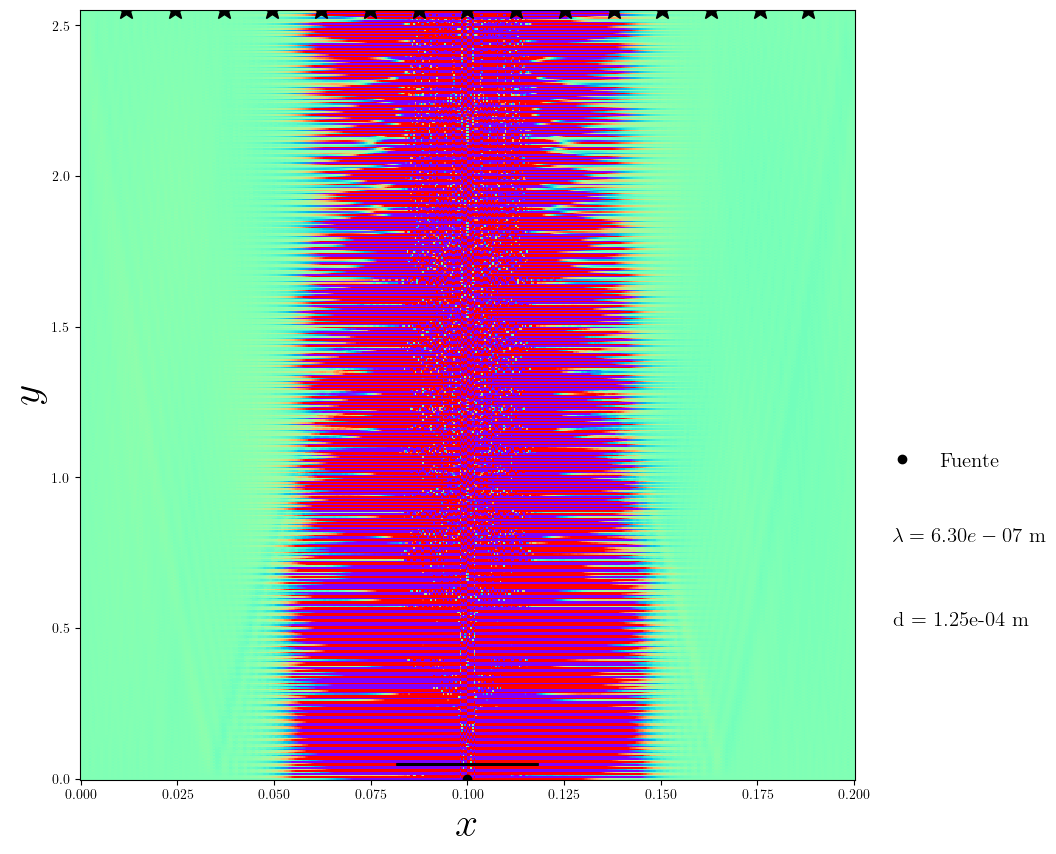

In [103]:
# Posiciones de las fuentes
source1 = np.array([x0, y0])

# Crear una malla de puntos en el plano XY
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Graficar las posiciones de los máximos de interferencia teóricos (si aplica)
m_values = range(-7, 8)  # Valores de m para los máximos
for m in m_values:
    x_max = m * (Ly-y_lamina) * lambda_/ s +x0 # Ecuación de máximos para red de difracción
    #if 0 <= x_max <= Lx:
    ax.plot(x_max, Ly, 'k*', ms=15)  # Graficar los máximos en y = Ly

# Graficar la onda propagada en el último paso de tiempo
c = ax.pcolormesh(X, Y, u[:, :, -1], cmap='rainbow', rasterized=True,  vmin=-A,vmax=A ) # vmin=-0.001,vmax=0.001,

#cargar datos de u

# Graficar la posición de la fuente
ax.plot(source1[0], source1[1], 'ko', label='Fuente')

# Graficar las posiciones de las láminas con agujeros
for x_lamina in x_laminas:
    #ax.axvline(x=x_lamina, ymin=0, ymax=1, color='k', linestyle='-', linewidth=1)
    ax.axhline(y=y_lamina, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)
    #ax.axhline(y=y_lamina + altura_lamina / 2, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)

# Información de parámetros
ax.text(Lx * 1.05, Ly / 3.25, f'$\lambda = {lambda_:.2e}$ m', fontsize=15)
ax.text(Lx * 1.05, Ly / 5, f'd = {s:.2e} m', fontsize=15)

# Etiquetas de los ejes
ax.set_xlabel(r'$x$', fontsize=30)
ax.set_ylabel(r'$y$', fontsize=30)


# Ajustar aspectos visuales
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.01, 0.45), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)

# Mostrar la figura
#plt.colorbar(c, ax=ax, label='Amplitud de la onda')
plt.show()

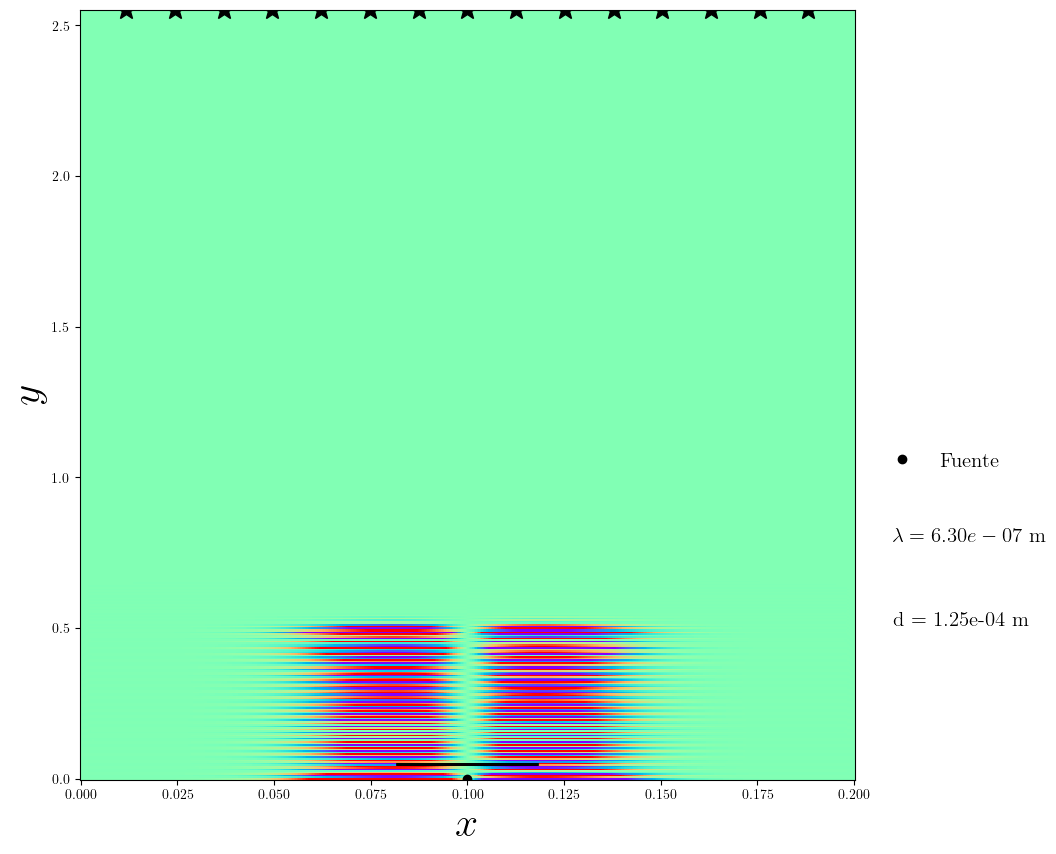

In [90]:
# Posiciones de las fuentes
source1 = np.array([x0, y0])

# Crear una malla de puntos en el plano XY
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Graficar las posiciones de los máximos de interferencia teóricos (si aplica)
m_values = range(-7, 8)  # Valores de m para los máximos
for m in m_values:
    x_max = m * (Ly-y_lamina) * lambda_/ s +x0 # Ecuación de máximos para red de difracción
    #if 0 <= x_max <= Lx:
    ax.plot(x_max, Ly, 'k*', ms=15)  # Graficar los máximos en y = Ly

# Graficar la onda propagada en el último paso de tiempo
c = ax.pcolormesh(X, Y, u[:, :, 100], cmap='rainbow', rasterized=True,  vmin=-A/16,vmax=A/16 ) # vmin=-0.001,vmax=0.001,

#cargar datos de u

# Graficar la posición de la fuente
ax.plot(source1[0], source1[1], 'ko', label='Fuente')

# Graficar las posiciones de las láminas con agujeros
for x_lamina in x_laminas:
    #ax.axvline(x=x_lamina, ymin=0, ymax=1, color='k', linestyle='-', linewidth=1)
    ax.axhline(y=y_lamina, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)
    #ax.axhline(y=y_lamina + altura_lamina / 2, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)

# Información de parámetros
ax.text(Lx * 1.05, Ly / 3.25, f'$\lambda = {lambda_:.2e}$ m', fontsize=15)
ax.text(Lx * 1.05, Ly / 5, f'd = {s:.2e} m', fontsize=15)

# Etiquetas de los ejes
ax.set_xlabel(r'$x$', fontsize=30)
ax.set_ylabel(r'$y$', fontsize=30)


# Ajustar aspectos visuales
#ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.01, 0.45), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)

# Mostrar la figura
#plt.colorbar(c, ax=ax, label='Amplitud de la onda')
plt.show()

In [25]:
f

15873015.873015873

In [70]:
##Vista superior Plano XY

filenames = []
frame_count = 0
for t in range(nt):
    if t % 5 == 0:
        fig, ax = plt.subplots(figsize=(7.5,10))
        ax.set_title(f'lambda: {lambda_} cm', fontsize=30)
        c = ax.pcolormesh(X, Y, u[:,:,t], cmap='rainbow',vmin=-10*A, vmax=10*A)
        ax.set_xlabel(r'$x$', fontsize=35)
        ax.set_ylabel(r'$y$', fontsize=35)
        #ax.set_aspect('equal')
    
    
        #cax = plt.axes([0.92, 0.33, 0.02, 0.25])
        #cbar = fig.colorbar(c,cax=cax, ax=ax, orientation='vertical', )
    
        #cbar.ax.tick_params(labelsize=20)
        filename = f'frames/frame_{frame_count}.png'
        plt.savefig(filename)
        filenames.append(filename)
        plt.close()
        frame_count += 1

v_name=f'Difraction_final_t_{round(nt,2)}.mp4'

os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)


In [ ]:
##Red de difracción

filenames = []
for t in range(nt):
    fig, ax = plt.subplots(figsize=(11, 10))
    #ax.set_title(f't: {t * dt:.2f}', fontsize=30)
    c = ax.pcolormesh(X, Y, u[:,:,t], cmap='rainbow', vmin=-A, vmax=A)
    ax.set_xlabel(r'$x$', fontsize=30)
    ax.set_ylabel(r'$y$', fontsize=30)
    #ax.set_aspect('equal')
    #ax.plot(xl,yl,'k-',label='Placa',lw=2)

    # Graficar la fuente
    ax.plot(source1[0], source1[1], 'ko')
    #ax.plot(source2[0], source2[1], 'bo', label='Fuente 2')

    
   # ax.axhline(y=y_lamina, xmin=0, xmax=1, color='k', linestyle='-')
    ax.text(Lx*1.01, Ly/3.25, f'$\lambda = {lambda_:.2f}$ m', fontsize=15)
    ax.text(Lx*1.01, Ly/4, f'd={s} m', fontsize=15)
    ax.text(Lx*1.01, Ly/4.5, f'$ R  = $ {Ly-y_lamina:.2f} m', fontsize=15)

    # Graficar los máximos de interferencia
    m_values = range(-10, 11)  # Valores de m para los máximos
    for m in m_values:
        x_max = m * (Ly - y_lamina) * lambda_ / s +Lx/2                 
        if 0 <= x_max <= Lx:
            ax.plot(x_max, Ly, 'k+', ms=10)  # Graficar los máximos en y = Ly

    for x_lamina in x_laminas:
    #ax.axvline(x=x_lamina, ymin=0, ymax=1, color='k', linestyle='-', linewidth=1)
        ax.axhline(y=y_lamina - altura_lamina / 2, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)
        ax.axhline(y=y_lamina + altura_lamina / 2, xmin=(x_lamina - s / 2) / Lx, xmax=(x_lamina + s / 2) / Lx, color='k', linewidth=2)
        
    # Graficar los puntos de interferencia constructiva
    #ax.scatter(X[constructive_interference], Y[constructive_interference], color='k', s=0.05, alpha=0.5, )
    
    #cax = plt.axes([0.85, 0.33, 0.02, 0.25])
    #cbar = fig.colorbar(c, cax=cax, ax=ax, orientation='vertical')
    #ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)
    #cbar.ax.tick_params(labelsize=20)
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

v_name = f'Red_nx_{nx}_nt_{nt}.mp4'

os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)

In [22]:
filenames = []
for t in range(nt):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f't: {t * dt:.2f}', fontsize=30)
    c = ax.pcolormesh(X, Y, u[:,:,t], cmap='rainbow', vmin=-10, vmax=10)
    ax.set_xlabel(r'$x$', fontsize=30)
    ax.set_ylabel(r'$y$', fontsize=30)
    ax.set_aspect('equal')
    #ax.plot(xl,yl,'k-',label='Placa',lw=2)

    # Graficar las fuentes
    ax.plot(source1[0], source1[1], 'bo')
    for x_lamina in x_laminas:
        ax.axvline(x=x_lamina, ymin=(y_lamina - dy/2)/Ly, ymax=(y_lamina + dy/2)/Ly, color='k', linestyle='-')
    #ax.axhline(y=y_lamina, xmin=0, xmax=1, color='k', linestyle='-')
    ax.text(Lx*1.05, Ly/3.25, f'$\lambda = {lambda_}$ m', fontsize=15)
    ax.text(Lx*1.05, Ly/4, f'f = {f:.2f} Hz', fontsize=15)
    ax.text(Lx*1.05, Ly/4.5, f'v = {v:.2f} m/s', fontsize=15)

    #ax.plot(source2[0], source2[1], 'bo', label='Fuente 2')
    
    # Graficar los puntos de interferencia constructiva
    #ax.scatter(X[constructive_interference], Y[constructive_interference], color='k', s=0.05, alpha=0.5, )
    
    #cax = plt.axes([0.85, 0.33, 0.02, 0.25])
    #cbar = fig.colorbar(c, cax=cax, ax=ax, orientation='vertical')
    ax.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0.5, fontsize=15, frameon=False)
    #cbar.ax.tick_params(labelsize=20)
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

v_name = f'Red_f_{f}_v_{v:.2f}.mp4'

os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)

In [19]:



# Posiciones de las fuentes
source1 = np.array([x0, y0])
#source2 = np.array([8 + d, 13])
d=8
# Crear una malla de puntos en el plano XY
x = np.linspace(0, Lx,nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

# Calcular las distancias desde cada punto a las dos fuentes
#r1 = np.sqrt((X - source1[0])**2 + (Y - source1[1])**2)
#r2 = np.sqrt((X - source2[0])**2 + (Y - source2[1])**2)

# Calcular la diferencia de fase
#delta_r = np.abs(r1 - r2)

# Identificar los puntos de interferencia constructiva
#constructive_interference = np.isclose(delta_r % lambda_, 0, atol=0.1)

##Vista superior Plano XY

filenames = []
for t in range(nt):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f't: {t * dt:.2f}', fontsize=30)
    c = ax.pcolormesh(X, Y, u[:,:,t], cmap='rainbow', vmin=-10, vmax=10)
    ax.set_xlabel(r'$x$', fontsize=3)
    ax.set_ylabel(r'$y$', fontsize=30)
    ax.set_aspect('equal')
    #ax.plot(xl,yl,'k-',label='Placa',lw=2)

    # Graficar las fuentes
    ax.plot(source1[0], source1[1], 'bo', label='Fuente')
    ax.axhline(y=y_lamina, xmin= (x_lamina1-longitud_lamina)/Lx, xmax=(x_lamina1)/Lx, color='k', linestyle='-')
    ax.axhline(y=y_lamina, xmin=(x_lamina2)/Lx, xmax=(x_lamina2+longitud_lamina)/Lx ,color='k', linestyle='-')
    ax.text(Lx+1, Ly/3.25, f'$\lambda = {lambda_:.2f}$ cm', fontsize=15)
    ax.text(Lx+1, Ly/4, f'f = {f:.2f} Hz', fontsize=15)
    ax.text(Lx+1, Ly/4.5, f'v = {v:.2f} cm/s', fontsize=15)

    #ax.plot(source2[0], source2[1], 'bo', label='Fuente 2')
    
    # Graficar los puntos de interferencia constructiva
    #ax.scatter(X[constructive_interference], Y[constructive_interference], color='k', s=0.05, alpha=0.5, )
    
    #cax = plt.axes([0.85, 0.33, 0.02, 0.25])
    #cbar = fig.colorbar(c, cax=cax, ax=ax, orientation='vertical')
    ax.legend(bbox_to_anchor=(1.005, 0.5), loc='upper left', borderaxespad=0.5, fontsize=15,frameon=False)
    #cbar.ax.tick_params(labelsize=20)
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

v_name = f'Difraccion_f_{f}_v_{v:.2f}.mp4'

os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 30 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)

In [16]:
import os
import subprocess

##Vista superior Plano XY

filenames = []
for t in range(nt):
    fig, ax = plt.subplots(figsize=(5, 10), dpi=100)
    ax.set_title(f't: {t * dt:.2f}', fontsize=35)
    c = ax.pcolormesh(X, Y, u[:,:,t], cmap='rainbow')
    ax.set_xlabel(r'$x$', fontsize=35)
    ax.set_ylabel(r'$y$', fontsize=35)
    ax.set_aspect('equal')
    
    cax = plt.axes([0.92, 0.33, 0.02, 0.25])
    cbar = fig.colorbar(c,cax=cax, ax=ax, orientation='vertical', )
    
    cbar.ax.tick_params(labelsize=25)
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

v_name = f'Esfericas_c_{c}_f_{f}.mp4'

# Ejecutar ffmpeg y capturar la salida
result = subprocess.run(
    ["ffmpeg", "-framerate", "60", "-i", "frames/frame_%d.png", "-c:v", "libx264", "-r", "30", "-pix_fmt", "yuv420p", v_name],
    capture_output=True,
    text=True
)

# Mostrar la salida de ffmpeg
print(result.stdout)
print(result.stderr)

# Eliminar los archivos de imagen
for filename in filenames:
    os.remove(filename)


ffmpeg version 7.0.1-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-l

In [17]:
import numpy as np
from scipy.special import jn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from numba import jit
import imageio
import os

rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

Lx = 10  
Ly=Lx
T = 10
nx= 350
ny=nx 
dx = Lx / (nx - 1)  
dy = Ly / (ny - 1)  
c = 2.5
safety_factor = np.sqrt(0.5) * 0.9  
dt = min(dx, dy) / c * safety_factor  
nt = int(T / dt) + 1  
u = np.zeros((nx, ny, nt))  

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

x0, y0 = Lx/4, 3*Ly/4 
 
r = Lx/2 

cx, cy = Lx/2, Ly/2  

u = np.zeros((nx, ny, nt))


from scipy.special import j0

sigma = 0.25  # Este parámetro puede ajustarse para controlar la extensión del sombrero mexicano

for i in range(nx):
    for j in range(ny):
        u[i, j, 0] = j0(np.sqrt((x[i] - x0)**2 + (y[j] - y0)**2) / sigma)

@jit(nopython=True)
def propagate_wave(u, nx, ny, nt, dx, dy, dt, cx, cy, r):
    u[:,:,1] = u[:,:,0]

    for t in range(1, nt - 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                if (i*dx - cx)**2 + (j*dy - cy)**2 < r**2:
                    u[i,j,t+1] = (2 * u[i,j,t] - u[i,j,t-1] +
                                  c**2 * dt**2 * (u[i+1,j,t] - 2 * u[i,j,t] + u[i-1,j,t]) / dx**2 +
                                  c**2 * dt**2 * (u[i,j+1,t] - 2 * u[i,j,t] + u[i,j-1,t]) / dy**2)
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, cx, cy, r)
D=np.sqrt((X - cx)**2 + (Y - cy)**2)

for t in range(nt):
    mask = D >= r
    u[:,:,t][mask] = np.nan 

filenames = []

for t in range(nt):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'$t$: {t * dt:.2f}',fontsize=35)
    ax.set_xlabel(r'$x$',fontsize=30)
    ax.set_ylabel(r'$y$',fontsize=30)
    ax.set_zlabel(r'$u$',fontsize=30)
    ax.tick_params(labelsize=20)

    surf=ax.plot_surface(X, Y, u[:,:,t], cmap='plasma',vmin=-0.33,vmax=1) #
    ax.set_zlim(-1.5, 1.5)
    cax=plt.axes([0.955, 0.4, 0.01, 0.25])

    cax.tick_params(labelsize=20)
    plt.colorbar(surf,cax=cax,orientation='vertical',ticks=[ -1,0,1])
    filename = f'frames/frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()


with imageio.get_writer('membrana1.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

v_name='Esferica.mp4'

os.system(f"ffmpeg -framerate 30 -i frames/frame_%d.png -c:v libx264 -r 60 -pix_fmt yuv420p {v_name}")

for filename in filenames:
    os.remove(filename)

ValueError: setting an array element with a sequence.

In [1]:
import numpy as np
from scipy.special import jn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from numba import jit
import imageio
import os

rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)

# Parámetros
Lx = 1  # dimensiones del dominio
Ly=Lx
T = 2 # tiempo total
nx= 300
ny=nx # número de intervalos en x y y
dx = Lx / (nx - 1)  # tamaño del intervalo en x
dy = Ly / (ny - 1)  # tamaño del intervalo en y
c = 3.5 # velocidad de la onda
safety_factor = np.sqrt(0.5) * 0.9  # factor de seguridad
dt = min(dx, dy) / c * safety_factor  # Calcular dt para cumplir con la condición de CFL
nt = int(T / dt) + 1  # número de intervalos de tiempo
u = np.zeros((nx, ny, nt))  # Inicializar la solución como una matriz de ceros

# Condiciones iniciales

x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)

x0, y0 = Lx/2., Ly/2  # centro de la gaussiana
sigma = 0.125  # desviación estándar de la gaussiana
r = Lx/2 # Radio de la circunferencia

cx, cy = Lx/2, Ly/2  # centro de la región circular

u = np.zeros((nx, ny, nt))

# Inicializar la onda como una gaussiana en el centro del dominiofor i in range(nx):
for i in range(nx-2):
    for j in range(ny-2):
        if (x[i] - cx)**2 + (y[j] - cy)**2 < 0.99*r**2:
            # Cambiar la función para modificar el patrón de la onda inicial 1.5*np.exp(-((x[i] - x0)**2 + (y[j] - y0)**2) / (2 * sigma**2))-0.25*np.sin(3*np.pi*np.sqrt((x[i] - x0)**2 + (y[j] - y0)**2))
            u[i,j,0] = jn(1,(np.pi*(x[i] - x0)))+0.25*jn(0,(np.pi*(y[j] - y0)))



@jit(nopython=True)
def propagate_wave(u, nx, ny, nt, dx, dy, dt, cx, cy, r):
    u[:,:,1] = u[:,:,0]
    for t in range(1, nt - 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                if (i*dx - cx)**2 + (j*dy - cy)**2 < 0.99*r**2:
                    u[i,j,t+1] = (2 * u[i,j,t] - u[i,j,t-1] +
                                  c**2 * dt**2 * (u[i+1,j,t] - 2 * u[i,j,t] + u[i-1,j,t]) / dx**2 +
                                  c**2 * dt**2 * (u[i,j+1,t] - 2 * u[i,j,t] + u[i,j-1,t]) / dy**2)
    return u

u = propagate_wave(u, nx, ny, nt, dx, dy, dt, cx, cy, r)
D=np.sqrt((X - cx)**2 + (Y - cy)**2)
# El resto del código para crear y guardar las imágenes y el gif permanece igual.
for t in range(nt):
    mask = D >= r
    u[:,:,t][mask] = np.nan 

filenames = []

for t in range(nt):
    fig = plt.figure(figsize=(10, 10),dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'$t$: {t * dt:.2f}',fontsize=30)
    ax.set_xlabel(r'$x$',fontsize=30)
    ax.set_ylabel(r'$y$',fontsize=30)
    ax.set_zlabel(r'$u$',fontsize=30)
    ax.tick_params(labelsize=20)

    surf=ax.plot_surface(X, Y, u[:,:,t],cmap='viridis', rasterized=True,vmin=-1.5,vmax=1.5)
    ax.set_zlim(-1.5, 1.5)
    cax=plt.axes([0.94, 0.4, 0.01, 0.25])

    cax.tick_params(labelsize=20)
    plt.colorbar(surf,cax=cax,orientation='vertical',ticks=[ -1,0,1])
    filename = f'frame_{t}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Crear el gif
with imageio.get_writer('membrana11.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Eliminar las imágenes
for filename in filenames:
    os.remove(filename)

In [8]:
with imageio.get_writer('membrana11.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Eliminar las imágenes
for filename in filenames:
    os.remove(filename)

C:\Users\nicor\AppData\Local\Temp\ipykernel_4232\2335253461.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
###
f=[923.1,1055,1729]
l=[3.5,2.5]
ld=[0,0,3.5,2]